## Dataset: Kaggle NLP with Disaster Tweets
Predict which Tweets are about real disasters and which ones are not
- https://www.kaggle.com/c/nlp-getting-started/overview

Deep Learning Dense Classifier with Convolution 1D using TensorFlow and Keras API

In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text
import preprocessor as p
from sklearn.model_selection import train_test_split

In [ ]:
!nvidia-smi

Thu Mar 17 01:46:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   57C    P3    21W /  N/A |    663MiB /  6144MiB |     69%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
path = ""

train_data_path = os.path.join(path, "data", "train.csv")
test_data_path = os.path.join(path, "data", "test.csv")

raw_data = pd.read_csv(train_data_path)
raw_data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
# Text cleaning - Removing URLs, mentions, etc using tweet-preprocessor package
def tweet_clean(tweet, lower_case = False, remove_digits = False,
                remove_punct = False, replace_amper = False,
                retrieve_hashtag = True):
  """
  Clean tweet with tweet-preprocessor p.clean() removing unwanted characters,
  user mentions, punctuations and setting to lower case text.

  Arguments:
  tweet -- Text string.
  lower_case -- Boolean. When True, will lower case tweets. Default = False.
  remove_digits -- Boolean. When True, will remove numbers from tweets.
  Default = False.
  remove_punct -- Boolean. When True, will remove punctuations from tweets.
  Default = False.
  replace_amper -- Boolean. When True, will replace HTML ampersand format for
  'and' stopword. Default = False.
  retrieve_hashtage -- Boolean. When True, will retrieve tweet hashtag in an
  independent series object 'hashtags'. Default = True.
  
  Returns:
  cleaned_tweet -- Cleaned tweet text string.
  hashtags -- List with hashtags extracted from tweet
  """
  # Remove user mentions, symbols and unwanted characters
  p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED,
                p.OPT.EMOJI, p.OPT.SMILEY)
  
  tweet = p.clean(tweet)

  # Lower case
  if lower_case:
    tweet = tweet.lower()

  # Remove digits
  if remove_digits:
    tweet = tweet.replace('\d+', '')

  # Remove punctuations
  if remove_punct:
    tweet = re.sub(r'[^\w\s]', '', tweet)
  
  # Replace amper
  if replace_amper:
    tweet = tweet.replace('&amp;', 'and')
    tweet = tweet.replace('&AMP;', 'and')

  if retrieve_hashtag:
    hashtags = re.findall(r'#(\w+)', tweet)
    tweet = tweet.replace('#', '')

  cleaned_tweet = tweet

  if retrieve_hashtag:
    return pd.Series([cleaned_tweet, hashtags])
  else:
    return cleaned_tweet

In [ ]:
raw_data['cleaned_text'] = raw_data['text'].apply(tweet_clean,
                                                  replace_amper = True,
                                                  retrieve_hashtag = False)
raw_data

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,The out of control wild fires in California ev...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(raw_data['cleaned_text'], raw_data['target'],
                                                  train_size = 0.8,
                                                  random_state = 1337,
                                                  shuffle = True,
                                                  stratify = raw_data['target'])

In [ ]:
print(f"Training data shape: {X_train.shape}")
print(f"Training label shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation label shape: {y_val.shape}")

Training data shape: (6090,)
Training label shape: (6090,)
Validation data shape: (1523,)
Validation label shape: (1523,)


In [ ]:
batch_size = 128
train_df = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size = batch_size)
val_df = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size = batch_size)

In [ ]:
list(train_df.as_numpy_iterator())[0]

(array([b'A young German stormtrooper engaged in the Battle of the Somme 1916. [800 582 ]',
        b"Don't like those head first slides. Especially into home !! #danger",
        b'Eric Clapton shot the sheriff in 1974 and guess how many people were rioting? Right none.',
        b'Monkeys Abused by Notorious Laboratory Dealer | A PETA Eyewitness Invest... via',
        b'peanut butter cookie dough blizzard is ??????????????????????',
        b'Its time to do away with drought.Check out how the #cloud #IOT are helping conserve water',
        b'Twelve feared killed in Pakistani air ambulance helicopter crash #worldnews',
        b'If you sit and rant on snapchat to your apparent fans when you have about 8000 followers I hope your in a train crash xoxo',
        b'social casualty',
        b'#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
        b'For those impacted by the #CalWildfires here a

In [ ]:
for inputs, targets in train_df:
  print("inputs.shape:", inputs.shape)
  print("inputs.dtype:", inputs.dtype)
  print("targets.shape:", targets.shape)
  print("targets.dtype:", targets.dtype)
  print("inputs[0]:", inputs[0])
  print("targets[0]:", targets[0])
  break

inputs.shape: (128,)
inputs.dtype: <dtype: 'string'>
targets.shape: (128,)
targets.dtype: <dtype: 'int64'>
inputs[0]: tf.Tensor(b'A young German stormtrooper engaged in the Battle of the Somme 1916. [800 582 ]', shape=(), dtype=string)
targets[0]: tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
print("Training set maximum length:", max([len(row.split()) for row in X_train]))

Training set maximum length: 31


In [ ]:
print("Validation set maximum length:", max([len(row.split()) for row in X_val]))

Validation set maximum length: 30


In [ ]:
max_length = 31

In [ ]:
# tf.config.run_functions_eagerly(False)
# Text vectorizer
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length)

# Text only tf.Datasets
text_only_train_df = train_df.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_df)

In [ ]:
# Creating integer sequences tf.Datasets
int_train_df = train_df.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls = 4)

int_val_df = val_df.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [ ]:
list(int_train_df.as_numpy_iterator())[0]

(array([[    3,   985,  1890, ...,     0,     0,     0],
        [   54,    25,   162, ...,     0,     0,     0],
        [11024, 11993,   592, ...,     0,     0,     0],
        ...,
        [  133,    12,  1081, ...,     0,     0,     0],
        [ 1424,  1101,   493, ...,     0,     0,     0],
        [  833,   238,   365, ...,     0,     0,     0]], dtype=int64),
 array([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1], dtype=int64))

In [ ]:
for inputs, targets in int_train_df:
  print("inputs.shape:", inputs.shape)
  print("inputs.dtype:", inputs.dtype)
  print("targets.shape:", targets.shape)
  print("targets.dtype:", targets.dtype)
  print("inputs[0]:", inputs[0])
  print("targets[0]:", targets[0])
  break

inputs.shape: (128, 31)
inputs.dtype: <dtype: 'int64'>
targets.shape: (128,)
targets.dtype: <dtype: 'int64'>
inputs[0]: tf.Tensor(
[    3   985  1890  6834 11069     4     2   578     6     2  7013  5617
  5571  5582     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0], shape=(31,), dtype=int64)
targets[0]: tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
# Model with a trained embedding layer
def get_model():
  inputs = layers.Input(shape = (max_length, ), dtype = "int64", name = "Input_Text")
  embedded = layers.Embedding(input_dim = max_tokens,
                              output_dim = 256,
                              mask_zero = True,
                              name = "Embedding")(inputs)
  # x = layers.Bidirectional(layers.LSTM(32), name = "Bidirectional_LSTM")(embedded)
  # x = layers.Dropout(0.5)(x)
  x = layers.SeparableConv1D(16, 3, activation = "relu")(embedded)
  x = layers.MaxPooling1D(2)(x)
  # x = layers.Conv1D(64, 3, activation = "relu")(x)
  # x = layers.MaxPooling1D(2)(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(16, activation = "relu")(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1, activation = "sigmoid", name = "Binary_Classifier")(x)

  model = tf.keras.Model(inputs, outputs)
  model.compile(optimizer = "adam",
                loss = "binary_crossentropy",
                metrics = ["accuracy", tf.keras.metrics.AUC(name = "auc")])
  
  return model

In [ ]:
model = get_model()
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Text (InputLayer)     [(None, 31)]              0         
                                                                 
 Embedding (Embedding)       (None, 31, 256)           5120000   
                                                                 
 separable_conv1d_10 (Separa  (None, 29, 16)           4880      
 bleConv1D)                                                      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 14, 16)           0         
 g1D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 224)               0         
                                                                 
 dropout_20 (Dropout)        (None, 224)               0  

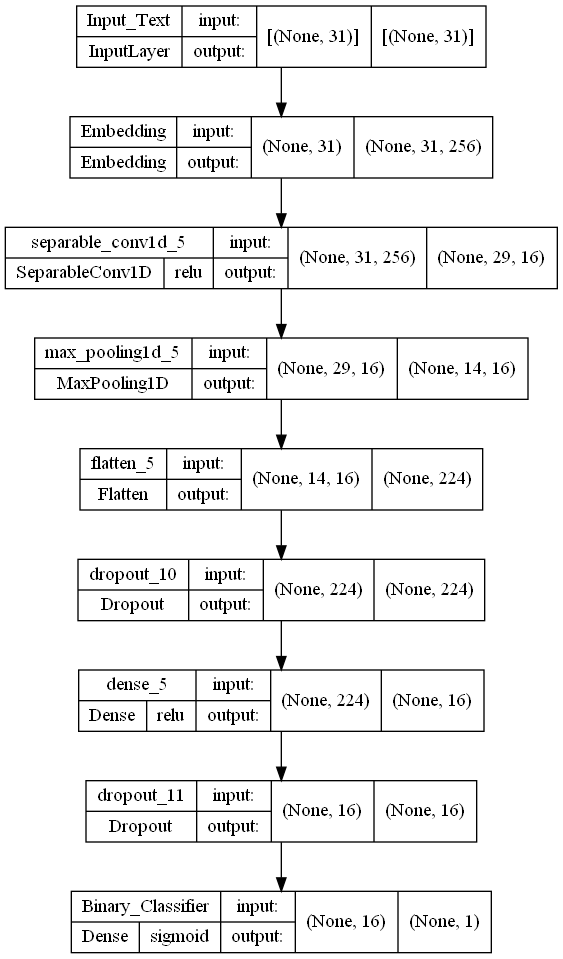

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_activations = True)

In [ ]:
# tf.config.run_functions_eagerly(True)
model_file_path = os.path.join(path, "models", "dense_16_SepConv1D.keras")

callbacks = [tf.keras.callbacks.ModelCheckpoint(model_file_path,
                                                save_best_only = True,
                                                monitor = 'val_loss')]

history = model.fit(int_train_df,
                    validation_data = int_val_df,
                    epochs = 10,
                    callbacks = callbacks)

Epoch 1/10
48/48 [==============================] - 2s 28ms/step - loss: 0.6893 - accuracy: 0.5649 - auc: 0.4996 - val_loss: 0.6817 - val_accuracy: 0.5706 - val_auc: 0.6239
Epoch 2/10
48/48 [==============================] - 1s 20ms/step - loss: 0.6510 - accuracy: 0.6287 - auc: 0.6681 - val_loss: 0.5636 - val_accuracy: 0.7531 - val_auc: 0.8120
Epoch 3/10
48/48 [==============================] - 1s 19ms/step - loss: 0.4375 - accuracy: 0.8182 - auc: 0.8735 - val_loss: 0.4503 - val_accuracy: 0.7912 - val_auc: 0.8570
Epoch 4/10
48/48 [==============================] - 1s 17ms/step - loss: 0.2890 - accuracy: 0.8977 - auc: 0.9416 - val_loss: 0.4896 - val_accuracy: 0.8004 - val_auc: 0.8548
Epoch 5/10
48/48 [==============================] - 1s 17ms/step - loss: 0.1949 - accuracy: 0.9374 - auc: 0.9726 - val_loss: 0.5814 - val_accuracy: 0.7919 - val_auc: 0.8440
Epoch 6/10
48/48 [==============================] - 1s 17ms/step - loss: 0.1483 - accuracy: 0.9581 - auc: 0.9824 - val_loss: 0.6614 - v

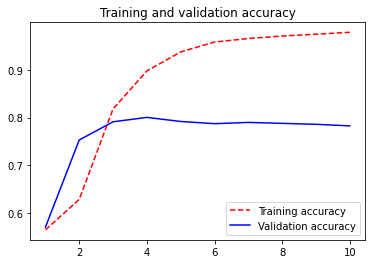

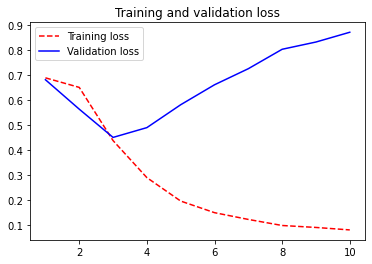

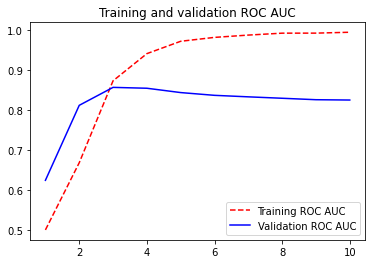

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
auc = history.history["auc"]
val_auc = history.history["val_auc"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "r--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b-", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b-", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.figure()
plt.plot(epochs, auc, "r--", label="Training ROC AUC")
plt.plot(epochs, val_auc, "b-", label="Validation ROC AUC")
plt.title("Training and validation ROC AUC")
plt.legend()
plt.show()

In [ ]:
# Evaluating the model
import numpy as np
from sklearn.metrics import f1_score, classification_report

model = tf.keras.models.load_model(model_file_path)
y_pred = model.predict(int_val_df)

In [ ]:
y_pred_hard = np.where(y_pred > 0.5, 1, 0)
f1_score(y_val, y_pred_hard)

0.7401960784313726

In [ ]:
print(classification_report(y_val, y_pred_hard))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       869
           1       0.79      0.69      0.74       654

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



In [ ]:
# Preparing complete df for final training on complete train.csv
X, y = raw_data['cleaned_text'], raw_data['target']

complete_df = tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size = batch_size)

# Text only tf.Datasets
text_only_complete_df = complete_df.map(lambda x, y: x)
text_vectorization.adapt(text_only_complete_df)

int_complete_df = complete_df.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [ ]:
# Fitting the model to the complete train.csv dataset
model = get_model()

history = model.fit(int_complete_df,
                    epochs = 5)

Epoch 1/5
60/60 [==============================] - 2s 18ms/step - loss: 0.6892 - accuracy: 0.5702 - auc: 0.4680
Epoch 2/5
60/60 [==============================] - 1s 14ms/step - loss: 0.6654 - accuracy: 0.5854 - auc: 0.6449
Epoch 3/5
60/60 [==============================] - 1s 15ms/step - loss: 0.5271 - accuracy: 0.7630 - auc: 0.8500
Epoch 4/5
60/60 [==============================] - 1s 15ms/step - loss: 0.3276 - accuracy: 0.8813 - auc: 0.9362
Epoch 5/5
60/60 [==============================] - 1s 15ms/step - loss: 0.1913 - accuracy: 0.9366 - auc: 0.9765


In [ ]:
# Processing test dataset
test_data = pd.read_csv(test_data_path)
test_text = test_data['text'].apply(tweet_clean,
                                    replace_amper = True,
                                    retrieve_hashtag = False)

test_df = tf.data.Dataset.from_tensor_slices((test_text)).batch(batch_size = batch_size)

int_test_df = test_df.map(
    lambda x: text_vectorization(x),
    num_parallel_calls=4)

In [ ]:
list(int_test_df.take(1).as_numpy_iterator())

[array([[ 29, 890,   3, ...,   0,   0,   0],
        [456,  52, 249, ...,   0,   0,   0],
        [ 74,   9,   3, ...,   0,   0,   0],
        ...,
        [  8, 290,   3, ...,   0,   0,   0],
        [  8, 290,   3, ...,   0,   0,   0],
        [ 29,  57,   6, ...,   0,   0,   0]], dtype=int64)]

In [ ]:
y_test = model.predict(int_test_df)
y_test_hard = np.where(y_test > 0.5, 1, 0)
y_test_hard

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
sample_submission_data_path = os.path.join(path, "data", "sample_submission.csv")
submission = pd.read_csv(sample_submission_data_path)
submission['target'] = y_test_hard
submission

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [ ]:
conv1D_submission_data_path = os.path.join(path, "data", "conv1D_submission.csv")
submission.to_csv(conv1D_submission_data_path, index = False, header = True)